# Logistic and linear regression with deterministic and stochastic first order methods

    TP 3 : Optimisation - DataScience Master
    Authors : Stéphane Gaiffas, Alexandre Gramfort
   
The aim of this TP is to implement and compare various batch and stochastic algorithms for logistic and ridge regression. Methods compared are gradient descent, accelerated gradient descent, L-BFGS, conjugate gradient for batch approaches and stochastic gradient descent (SGD), stochastic averaged gradient (SAG) and stochastic variance reduced gradient (SVRG) for the online approaches.

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with a general proximal operator and non-smooth regularizations.

This work should be done by pairs of students. One document for each pair of students should be sent to:

stephane.gaiffas@cmap.polytechnique.fr

**PLEASE use as object/title for your email "TP3-DS-Optim"**

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [33]:
%matplotlib inline

In [34]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2
$$
where
- $\ell(z, y) = \frac 12 (y - z)^2$ (least-squares regression)
- $\ell(z, y) = \log(1 + \exp(-yz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(\theta)
$$
where
$$
f_i(\theta) = \ell(x_i^\top \theta, y_i) + \frac \lambda 2 \|\theta\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(\theta) = (x_i^\top \theta - y_i) x_i + \lambda \theta
$$
and
$$
\nabla f_i(\theta) = - \frac{y_i}{1 + \exp(y_i x_i^\top \theta)} x_i + \lambda \theta.
$$

Let us recall also that theoretical step-size for the full-gradient method is $1 / L$, where $L$ is the Lipshitz constant of $\nabla f$. It is given by

$$
L = \frac{ \|\mathbf X^\top \mathbf X \|_{\text{op}}}{n}
$$
for the least-squares case and by
$$
L = \frac{\sum_{i=1, \ldots, n} \| x_i \|_\infty^2}{4n}
$$
for the logistic case.

We now introduce a class that will be used for the solvers.

In [35]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        return A.T.dot(A.dot(x) - b) / self.n + self.lbda * x

    def loss(self, x):
        return norm(A.dot(x) - b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        a_i = A[i]
        return (a_i.dot(x) - b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.max(svd(self.A, full_matrices=False)[1]) ** 2 / self.n + self.lbda
        return L

In [36]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda #Lambda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = np.sum(np.max(self.A ** 2, axis=1)) / (4. * self.n) + self.lbda
        return L

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [37]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x_truth) + noise
    return A, b

In [38]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    A, b = simu_linreg(x, n, std=1., corr=0.5)
    return A, np.sign(b)

In [39]:
d = 50
n = 10000
idx = np.arange(d)


corr=0.5
#corr=0.9
lbda = 1. / n ** (0.5)
#lbda = 1. / n

# Ground truth coefficients of the model
x_truth = (-1) ** (idx - 1) * np.exp(-idx / 10.)

#A, b = simu_linreg(x_truth, n, std=1., corr=0.7)
A, b = simu_linreg(x_truth, n, std=1., corr=corr)


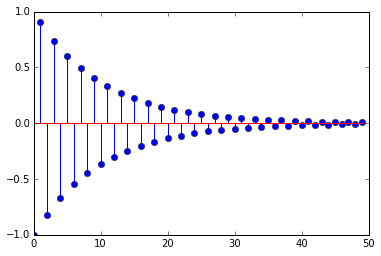

In [40]:
plt.stem(x_truth);

### Numerically check loss and gradient

In [41]:
from scipy.optimize import check_grad

#lbda = 1. / n ** (0.5)
#lbda = 1. / n
model = LinReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

3.2146676084200925e-06

In [42]:
#lbda = 1. / n ** (0.5)
#lbda = 1. / n
model = LogReg(A, b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

1.5757225043372829e-07

### Choice of the model

In [43]:
#model = LinReg(A, b, lbda)
model = LogReg(A, b, lbda)

### Compute the theoretical step-size for FISTA

In [44]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant() #pour gradient batch

print("step = %s" % step)

step = 0.634165797957


### Get a very precise minimum to compute distances to minimum

In [45]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-20)
print(f_min)

0.409098447005


<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BGFS)

Before implementing the logic of GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about current the minimization process.

In [46]:
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

In [47]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Ista solver in the cell below

In [48]:
def ista(x_init, grad, n_iter=100, step=1., callback=None): # on ne fait pas de critere d arret pr l instant on va comparer su un # d iterations donne
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x_new = x - step*grad(x)
        x = x_new 
        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)

    return x

In [49]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_truth, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err   
       0 | 1.72e-01 | 2.31e+00
      10 | 4.50e-02 | 1.45e+00
      20 | 2.16e-02 | 1.06e+00
      30 | 1.19e-02 | 8.11e-01
      40 | 6.99e-03 | 6.34e-01


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the Fista solver in the cell below

In [50]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        ### TODO
        x_new = y - step*grad(y)
        t_new = (1. + float(np.sqrt(1 + 4*(t**2))))/2.
        #t_new = (1. + (1. + 4. * t**2)) ** (0.5) / 2.
        y[:] = x_new + (x_new-x)*(t-1)/t_new
        x=x_new
        t=t_new

        ### END TODO

        # Update metrics after each iteration.
        if callback: 
            callback(x)
    return x

In [51]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_truth, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)# on appelle callback a toute les iterations et pr les SGD toutes les n iterations

   it    |   obj    |   err   
       0 | 1.72e-01 | 2.31e+00
      10 | 1.35e-02 | 8.60e-01
      20 | 4.57e-05 | 5.35e-02
      30 | 3.78e-04 | 1.59e-01
      40 | 5.25e-05 | 5.86e-02


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [52]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_truth, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err   
       0 | 1.39e-01 | 2.15e+00
      10 | 2.66e-05 | 3.41e-02
      20 | 1.25e-09 | 3.08e-04
Optimization terminated successfully.
         Current function value: 0.409098
         Iterations: 22
         Function evaluations: 48
         Gradient evaluations: 48


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [53]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_truth, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err   
       0 | 1.02e-01 | 1.75e+00
      10 | 7.49e-07 | 4.25e-03


### A first numerical comparison of deterministic solvers

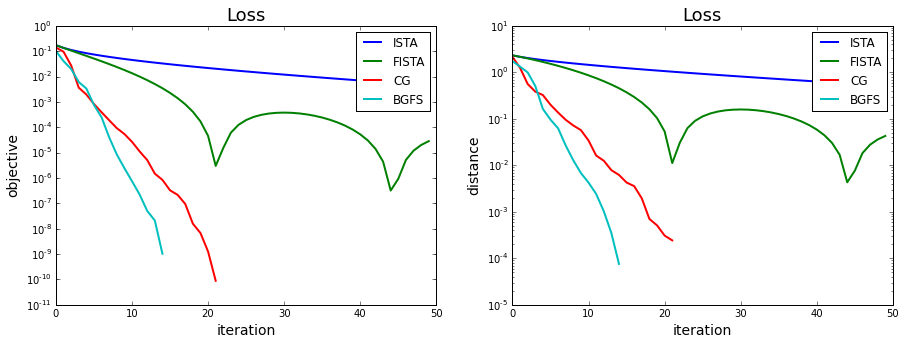

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("distance", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

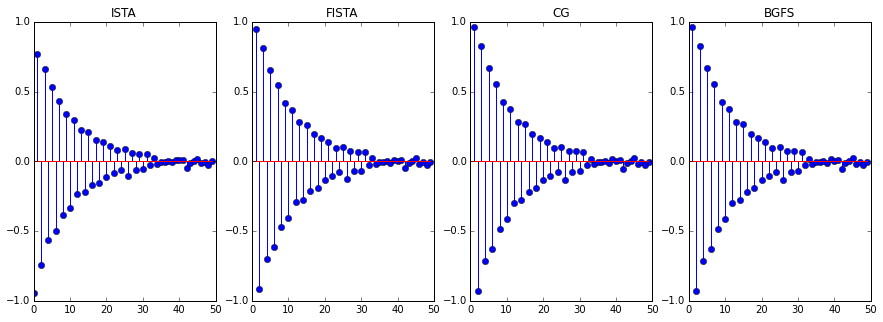

In [55]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about Fista, is it suprising ?

*REPONSES*:

- The batch algortihm we implemented are pretty much normal as they decrease (more slowly than BFGS) to the minimum of the function
- Fista decrease more faster than ISTA, that is normal given the fact that it is an accelerated algorithm (the theoretical convergence rate of ISTA is $O(1/t)$ and FISTA is $O(1/t^2)$, if $step<=1/L$)
- However we also notice that FISTA is not strictly descending (the same way as ISTA for example). It is due to the fact that the next iterations $x_{k+1}$ are gradient steps at extrapolated points $y_k$, this leading to some rare points that can make the loss funtion increase sometimes


<a id='stoc'></a> 
## 4. Stochastic methods

In [56]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)
iis.shape

(500000,)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [57]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x_new = x - (step/np.sqrt(idx+1))*grad_i(i,x)
        x = x_new
        
        ### END TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [58]:
step0 = 1.
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_truth, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err   
       0 | 1.01e+01 | 1.35e+01
      10 | 2.87e-03 | 2.00e-01
      20 | 1.42e-03 | 1.48e-01
      30 | 2.16e-03 | 1.83e-01
      40 | 1.11e-03 | 1.26e-01


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [59]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    
    ### done
    mean_gradient = np.mean(gradient_memory,0)
    ###end 

    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        mean_gradient = mean_gradient + (grad_i(i,x)-gradient_memory[i,:])/n
        x_new = x-step*mean_gradient
        #x_new = x - (step/np.sqrt(idx+1))*mean_gradient
        x = x_new
        gradient_memory[i,:] = grad_i(i,x)

        ### END OF TODO
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [60]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda / model.n)
else:
    step = 1.0 / (max_squared_sum + model.lbda / model.n)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_truth, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err   
       0 | 2.84e-01 | 2.60e+00
      10 | 1.11e-02 | 4.24e-01
      20 | 2.47e-03 | 1.36e-01
      30 | 1.04e-03 | 1.10e-01
      40 | 1.84e-04 | 4.98e-02


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [61]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    #line added
    xt = x.copy()
    
    for idx in range(n_iter):
        
        ### TODO
        y=np.zeros(np.size(x))
        if idx % n == 0:
            x[:] = xt
            mu = grad(x)
            
            
        i = iis[idx]
        xt -= step * (grad_i(i,xt)-grad_i(i,x)+mu)
#         y += xt
        
#         if idx % n == 0 and idx!=0:  
#             y=y/float(n)
#             xt[:]=y
            
        

        
        ### END TODO        
        
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(x)
    return x

In [62]:
step = 1. / (20. * model.lipschitz_constant())

x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_truth, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err   
       0 | 2.84e-01 | 2.60e+00
      10 | 3.15e-04 | 5.86e-02
      20 | 1.06e-06 | 3.37e-03
      30 | 2.27e-08 | 5.42e-04
      40 | -9.09e-10 | 1.61e-04


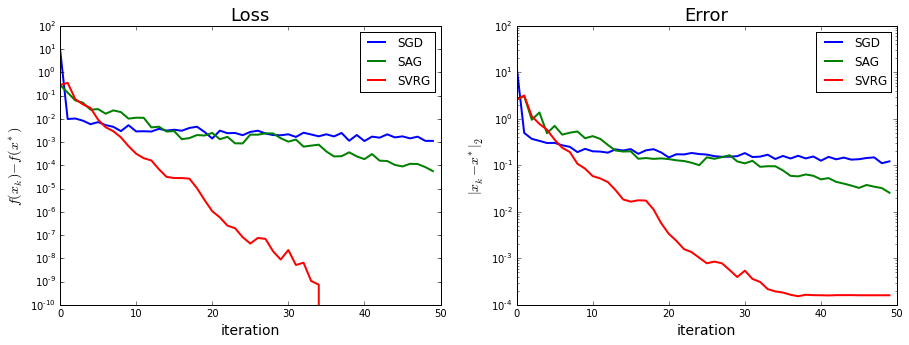

In [63]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Error", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

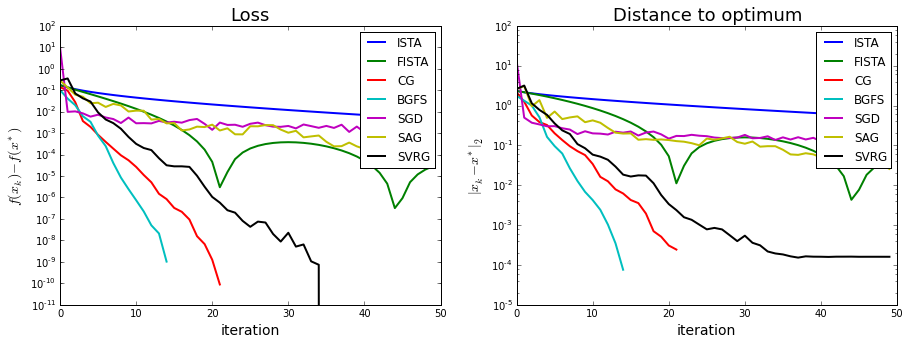

In [64]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

# inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
#               sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BGFS", "SGD", "SAG", "SVRG"]

# solvers = ["ISTA", "FISTA", "CG", "BGFS", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.plot(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("iteration", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    plt.yscale("log")

plt.legend(solvers);

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

### Theoretical convergence rates
<table>
   <tr>
       <th>ISTA</th>
       <th>FISTA</th>
       <th>CG</th>
       <th>BGFS</th>
       <th>SGD.........</th>
       <th>SAG.........</th>
       <th>SVRG</th>
   </tr>
   <tr>
       <td>$O(1/\alpha k)$, si $\alpha <= 1/L$ </td>
       <td>$O(1/\alpha k^2)$, si $\alpha <= 1/L$</td>
       <td>$O(\frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1})^k$, with $\kappa=L/\mu$ the conditionning </td>
       <td>$O(\rho ^k)$, ne depend pas kappa</td>
       <td>$O(1/\sqrt{k})$</td>
       <td>$O(1/k)$ <br />
           $O(\rho ^k)$, if $f_i$ u-s.cux</td>
       <td>$0.9^S$, if $n>>\kappa$ <br />
        ($f_i$ L-smooth & u-s.cux)</td>
   </tr>

</table>

### Comparaison of the algorithms
*Case : High correlation*: the problem is then bad conditionned, $\kappa$ is high
- least square:
    - $\lambda = 1 / \sqrt n$ :SGD can't perform optimization, ISTA too seem to be very slow. BGFS and CG are worse than in the case of low corellation
    - $\lambda = 1 / n$ :  Even that we an ill-problem, the FISTA and particulary SVRG porform well because of the strong convexity of f due to the high value of $lambda$
    
- logistic:
    - $\lambda = 1 / \sqrt n$ : In this case, SVRG,Ista and FISTA perform poorly as they depend on the condition number (see the table above)
            
    - $\lambda = 1 / n$ : These algorithms don't perform better than in the previous case. CG erforms less well cause it doesnt use the fact the f is more strongly convex
    
*Case : low correlation*: the problem is then well conditionned, $\kappa$ is low
- least square:
    - $\lambda = 1 / \sqrt n$ : The stochastic algorithms seem to be slower than the logistic case. SAG is faster SVRG cause f is probably not very strongly convex, we will confirm that in the next case by increasing strong convexity with $\lambda$. 
    - $\lambda = 1 / n$ :  The parameter does not improve the rate of SVRG, we are probably in the case where the steps of the iteration of the descent is not well set
    
- logistic:
    - $\lambda = 1 / \sqrt n$ : SVRG, BGFS, and CG have a linear convergence. This confirm the theoretical results
            
    - $\lambda = 1 / n$ :SVRG converges almost as well as BFGS (even though) cause in this case f is very strogly convex